### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 20  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289861639762322e-06


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


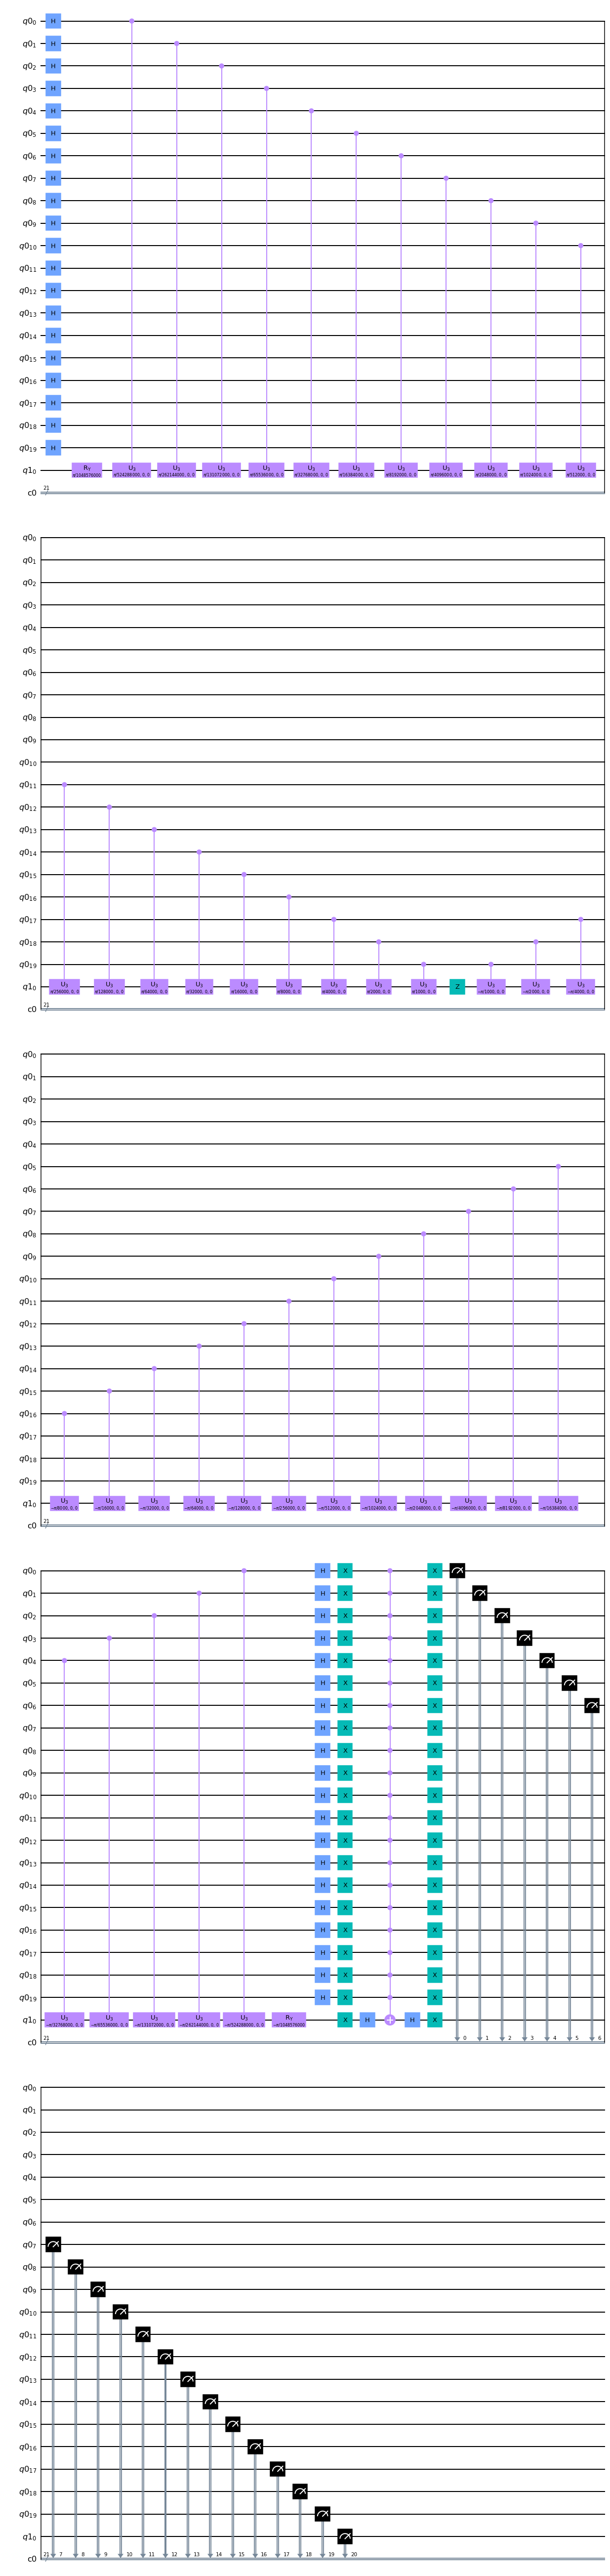

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.97, 0.03],[0.03,0.97]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [8]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [9]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.6449921131134033 s
1 th round with 1 oracles
0.21634197235107422 s
2 th round with 2 oracles
0.2786262035369873 s
3 th round with 3 oracles
0.3996882438659668 s
4 th round with 4 oracles
0.5160689353942871 s
5 th round with 5 oracles
0.5434229373931885 s
6 th round with 6 oracles
0.6270368099212646 s
7 th round with 7 oracles
0.7375097274780273 s
8 th round with 8 oracles
0.8073399066925049 s
9 th round with 9 oracles
0.9953148365020752 s
10 th round with 10 oracles
0.8785920143127441 s
11 th round with 11 oracles
1.2124402523040771 s
12 th round with 12 oracles
2.0764520168304443 s
13 th round with 13 oracles
2.438807249069214 s
14 th round with 14 oracles
2.036987066268921 s
15 th round with 15 oracles
2.2555079460144043 s
16 th round with 16 oracles
3.3145651817321777 s
17 th round with 17 oracles
2.858509063720703 s
18 th round with 18 oracles
3.170374870300293 s
19 th round with 19 oracles
2.9741709232330322 s
20 th round with 20 oracles
4.1897420883178

In [14]:
import pickle
with open("raw_result_20_003_003_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_20_003_003_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[56, 46, 56, 46, 50, 41, 53, 55, 43, 46, 45, 38, 54, 42, 41, 43, 38, 36, 33, 23, 28, 41, 25, 35, 20, 17, 18, 20, 14, 12, 17, 12, 12, 11, 10, 7, 3, 6, 1, 0, 0, 1, 1, 3, 2, 1, 2, 4, 2, 6, 5, 5, 6, 9, 5, 11, 10, 14, 11, 21, 22, 23, 21, 21, 31, 34, 35, 27, 37, 25, 29, 42, 40, 51, 40, 41, 51, 47, 53, 47, 48, 50, 54, 55, 49, 52, 52, 54, 52, 42, 59, 48, 55, 50, 49, 48, 47, 51, 47, 43]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3279483430340508
sum of mitigated probability vector x_hat_s: 1.3279483713558642
number of positive values:  24
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3627864728793193
sum of mitigated probability vector x_hat_s: 1.3627865031860922
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.402876523266038
sum of mitigated probability vector x_hat_s: 1.4028765439890007
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4092760615178879
sum of mitigated probability vector x_hat_s: 1.4092760940182663
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Mul

sum of mitigated probability vector x_s: 1.5293520547250963
sum of mitigated probability vector x_hat_s: 1.5293520677964259
number of positive values:  31
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4359386140003183
sum of mitigated probability vector x_hat_s: 1.4359386093358633
number of positive values:  31
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4176454657015167
sum of mitigated probability vector x_hat_s: 1.4176454983038012
number of positive values:  30
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4145103642386396
sum of mitigated probability vector x_hat_s: 1.4145103709067648
number of positive values:  31
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s:

sum of mitigated probability vector x_s: 1.5398929382262163
sum of mitigated probability vector x_hat_s: 1.5398929527928058
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4717785292514816
sum of mitigated probability vector x_hat_s: 1.471778531169124
number of positive values:  33
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4460058303791707
sum of mitigated probability vector x_hat_s: 1.4460058456224623
number of positive values:  29
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3612559201912262
sum of mitigated probability vector x_hat_s: 1.3612559495069965
number of positive values:  25
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 

In [12]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney_list)

The heuristcs by Mooney et al. + SGS algorithm
{4097: 0.019058699158223214, 1032: 0.018441816885836786, 131136: 0.018346052749867562, 544: 0.01809908148905513, 10240: 0.017443067818251945, 24576: 0.01783960339573319, 1024: -0.015091143800707975, 131072: -0.012463589034856051, 262144: 0.02413516537136377, 40960: 0.017283536874244304, 128: -0.017977097589295526, 65536: 0.02163660289551656, 8192: 0.024672306036012153, 1048576: 0.024820261682244486, 520: 0.01799670396102401, 272385: 0.019109100272752387, 172032: 0.01851614398542194, 32768: -0.013785907773592518, 67584: 0.017311637454008825, 0: 1.0479532635964608}
sum of counts: 1.283345305427565
number of positive values:  16
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{513: 0.018552104671207836, 131077: 0.019051591586607013, 24: 0.01700897572064105, 147456: 0.016974042102198023, 32832: 0.017153328755096106, 8224: 0.017662666358414465, 12288: 0.017062061745149102, 1114112: 0.01652284142632686, 524802: 0.0191474658579

{1576960: 0.01621643084056556, 8193: 0.019099481694274903, 65536: 0.021969323189951595, 1049616: 0.0190491690227286, 8200: 0.018413865467023484, 1051648: 0.01848639536954581, 1064962: 0.018609810074404334, 1048584: 0.025441264166250952, 128: 0.020874331583814618, 1048832: 0.02592768594829481, 524288: 0.02055469165460101, 32768: 0.02371040355671186, 65664: 0.016827513517086754, 1573888: 0.015990007450778308, 1310720: 0.06276842283150137, 1311232: 0.017108199318696518, 1048609: 0.019121167660476102, 1572864: 0.08097040870651052, 1026: 0.019063409465042914, 64: 0.022463309823022398, 1064992: 0.018592542818823072, 278528: 0.018463720227554853, 8: 0.022331396726605696, 1187840: 0.019078095310927596, 1048576: 0.3738767322665331, 1327104: 0.016369073846669604, 0: 0.45367873304200834}
sum of counts: 1.4250555855804046
number of positive values:  27
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{131200: 0.018198423607715668, 1114112: 0.026511540274215914, 1703936: 0.0354163

{1180672: 0.015980083705586543, 1050640: 0.01855690871991531, 1064961: 0.01849397949509051, 1048594: 0.018598130763752167, 1114116: 0.017137566988695774, 1310848: 0.015035562652511535, 1052672: 0.04278874865151073, 1378328: 0.0190156265715135, 1574920: 0.018495339365337822, 1179648: 0.07935348384892, 1572868: 0.03322901528527578, 1703940: 0.01801408157082065, 2: 0.03502316043389734, 1310720: 0.06021394713592593, 1048640: 0.022016914012905554, 1065280: 0.01908271439688376, 262144: 0.013530578432335754, 1196032: 0.03542150050248967, 1049092: 0.016497729817992707, 2048: 0.03480025906394961, 0: 0.09518066061202676, 1855489: 0.01902761148127293, 1048580: 0.04176245276739766, 1048704: 0.03893898986348575, 1573120: 0.015573175002329943, 1048576: 0.4703385231352218, 1574912: 0.015162448204847224, 1049088: 0.043270094429314544, 524416: 0.01839765368594595, 1081856: 0.01733600079294159, 128: 0.013142131629980304, 1048584: 0.042426821360020274, 1572864: 0.0961967057690427}
sum of counts: 1.478038

{1312768: 0.019094760244687467, 1065984: 0.019061131577756754, 2640: 0.019166803334232846, 73808: 0.01901073496516452, 257: 0.019049116507524604, 1310721: 0.018463768729540645, 65536: 0.021348089389820496, 16: 0.023161654942650524, 4096: 0.041953372397511714, 324: 0.018477825976087155, 4133: 0.01916436535750364, 4: 0.0426575930322497, 557568: 0.01909942906452518, 32768: 0.041662377277692925, 524288: 0.01884741574956568, 1179720: 0.019008622472863442, 271360: 0.01904428573254883, 1581088: 0.019125970767147903, 1576960: 0.015629237331884267, 1310722: 0.01910668953451931, 260: 0.017168751611739544, 1050632: 0.019118799978093844, 0: 0.4873468447994658, 1572864: 0.09919345690502983, 1048576: 0.4172823106031352}
sum of counts: 1.4922434082829417
number of positive values:  25
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1179648: 0.011369774993359545, 1573056: 0.018898658083458475, 4: 0.018316433879925407, 1114112: 0.01163033673528421, 262152: 0.01844414595701814, 10813

{10240: 0.019135563838533605, 32768: -0.013193855327656524, 524288: -0.01534136210151653, 8: 0.02574119154816896, 33024: 0.01846184665168674, 327680: 0.01646396275510338, 1179648: 0.017171033376862363, 64: 0.06090379375150919, 0: 1.0289437870137015, 1310722: 0.01910668953451931, 1040: 0.017346376856981018, 1056768: 0.016965589961863075, 262144: 0.04255001848050508, 12296: 0.01911149696962358, 131072: -0.011896157175272521, 1048576: 0.04112894777735197, 1572864: 0.05516942092600538, 1024: 0.023606036010562492}
sum of counts: 1.3813743808485321
number of positive values:  15
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{18436: 0.019154752017881964, 72: 0.016909436607488285, 1573376: 0.019140373616113697, 131072: 0.0479173438419482, 65544: 0.015731638628317123, 524288: -0.010926980204862272, 4: 0.0312623897345989, 1146880: 0.01901560882677258, 0: 0.9312683931989296, 2081: 0.019116310032887315, 524304: 0.01843354854522707, 1048578: 0.019133149761748288, 8: 0.045984408

In [20]:
import pickle
with open("hit_list_20_003_003.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [21]:
# import pickle
# with open("mit_hit_S_list_20_003_003.pkl", "wb")as f:
#     pickle.dump(mit_hit_S_list, f)

In [13]:
import pickle
with open("mit_hit_S_lm_0_list_20_003_003.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [14]:
import pickle
with open("mit_hit_mooney100_list_20_003_003.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [23]:
with open("hit_list_20_003_003.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_20_003_003.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_20_003_003.pkl", "rb") as f:
    mit_hit_mooney_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

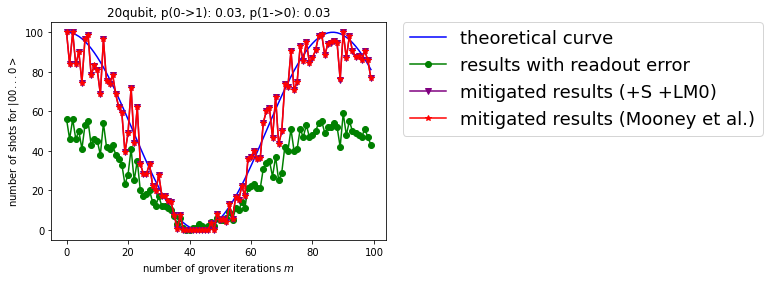

In [15]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("20qubit, p(0->1): 0.03, p(1->0): 0.03")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [16]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney_list = [100 - h for h in mit_hit_mooney_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney_list = calculate_theta(
    sin_mit_hit_mooney_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney_list = np.abs(np.sin(thetaCandidate_mit_mooney_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

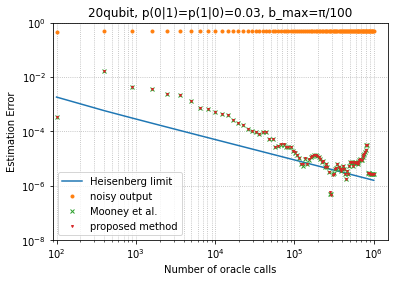

In [17]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("20qubit, p(0|1)=p(1|0)=0.03, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al.", "proposed method"))
plt.show()